In [1]:
%load_ext autoreload

%autoreload 2

In [26]:
%matplotlib inline

from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.ndimage import distance_transform_edt
import skimage as sk

import emc2d

np.random.seed(2020)

## SImulated data

In [27]:
intensity = np.load("./data/4BED_t40_d5000.npy")

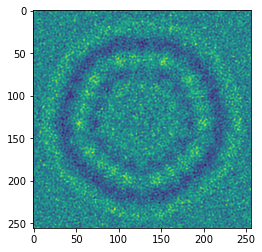

In [28]:
plt.imshow(intensity)

In [29]:
drift_radius = (15, 15)
mean_count= 0.05
motion_sigma = 1.
num_frames = 500
frame_size = (128, 128)
model_size = (frame_size[0] + 2*drift_radius[0], frame_size[1] + 2*drift_radius[1])
model = emc2d.sim.build_model(intensity, model_size=model_size, mean_count=mean_count)
n_drifts = (2*drift_radius[0] + 1) * (2*drift_radius[1] + 1)

frames, traj = emc2d.sim.generate_frames(
    intensity, 
    frame_size, 
    drift_radius=drift_radius, 
    num_frames=num_frames, 
    mean_count=mean_count, 
    motion_sigma=motion_sigma)

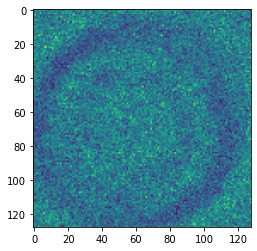

In [30]:
plt.imshow(frames[:].sum(0))

## Initialize EMC

In [31]:
emc = emc2d.core.EMC(
    frames=frames, 
    frame_size=(128, 128), 
    drift_radius=drift_radius, 
    init_model='random')

nnz / data_size = 4.76%, using dense data format


Text(0.5, 1.0, 'initial model')

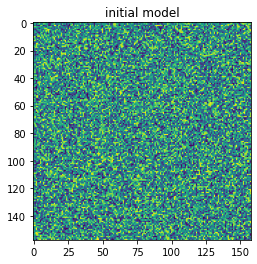

In [32]:
plt.imshow(emc.curr_model)
plt.title("initial model")

## Coarse graining the drift space

In [33]:
drift_in_use2 = emc2d.utils.drift_space_coarse_grain(drift_radius=drift_radius, multiple=(2, 2))
print(f"drifts {(2*drift_radius[0] + 1) * (2*drift_radius[1] + 1)} reduced to  {len(drift_in_use2)}")

drifts 961 reduced to  225


In [34]:
emc.run(iterations=10, drifts_in_use=drift_in_use2, lpfs=2.0)

100%|██████████| 10/10 [00:01<00:00,  7.47it/s]                                                                        


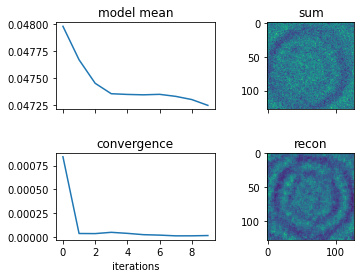

In [35]:
fig = emc2d.viz.show_emc_state(emc)

mse = 117.008


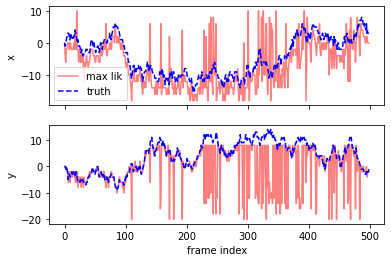

In [36]:
recon_drifts, recon_model = emc.centre_by_first_frame()
mse = emc2d.sim.mse_error(recon_drifts, true_traj=traj)
fig2 = emc2d.viz.show_maximum_likelihood_drifts(emc, true_traj=traj)

print(f"mse = {mse}")

In [37]:
pmat0 = emc.folded_membership_probability
bmap0 = emc.binary_location_map(threshold=1e-3)

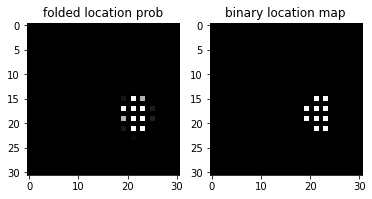

In [38]:
_, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(pmat0[0], vmin=0, vmax=0.005, cmap='gray')
ax2.imshow(bmap0[0], cmap='gray')
ax1.set_title("folded location prob")
ax2.set_title("binary location map");

## Select subregions for each frame

In [222]:
def broaden_searching_regions(bmap, r: int = 2):
    bmap_not = np.logical_not(bmap)
    bmap_new = np.array([distance_transform_edt(bmap_not[k]) < r for k in range(bmap.shape[0])])
    return bmap_new

def impose_continuity(bmap, broaden_r: int = 2):
    
    def broaden(bm, r: int):
        bm_not = np.logical_not(bm)
        return distance_transform_edt(bm_not) < r
    
    n_frames = bmap.shape[0]
    bmap_new = np.copy(bmap)
    
    # find clusters in bmap_new[0]
    lmap, nccs = sk.measure.label(bmap_new[0], return_num=True)
    cnts = [np.mean(np.argwhere(lmap == n), axis=0) for n in range(1, nccs+1)]
    if nccs > 1:
        # TODO
        cnts0 = cnts[0]
        bmap_new[0] = (lmap == 1).astype(np.bool)
    else:
        cnts0 = cnts[0]

    for k in range(1, n_frames):
        commons = np.logical_and(bmap_new[k], bmap_new[k-1])
        if not np.any(commons):
            bmap_new[k] = broaden(bmap_new[k-1], broaden_r)
            
        lmap, nccs = sk.measure.label(bmap_new[k], return_num=True)
        cnts = np.array([np.mean(np.argwhere(lmap == n), axis=0) for n in range(1, nccs+1)]) # (nccs, 2)
        dists = np.sum((cnts - cnts0)**2, axis=1) # (nccs, )
        chosen_label = np.argmin(dists) + 1
        bmap_new[k] = (lmap == chosen_label).astype(np.bool)
        cnts0 = cnts[chosen_label - 1]

    return bmap_new


def bmap_to_frame_drift_indices(bmap):
    n_frames = bmap.shape[0]
    bmap_r = bmap.reshape(n_frames, -1)
    return [np.argwhere(b).squeeze() for b in bmap_r]

In [241]:
bmap1 = broaden_searching_regions(bmap0, r=3)
bmap2 = impose_continuity(bmap1, broaden_r=3)

frame_drifts_in_use = bmap_to_frame_drift_indices(bmap2)

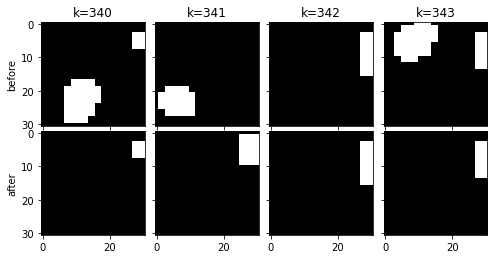

In [242]:
k0 = 340
_, axes = plt.subplots(nrows=2, ncols=4, sharex='all', sharey='all', figsize=(8, 4))

for i, ax in enumerate(axes[0]):
    ax.imshow(bmap1[k0 + i], cmap='gray')
    ax.set_title(f"k={k0+i}")
    
for i, ax in enumerate(axes[1]):
    ax.imshow(bmap2[k0 + i], cmap='gray')
    
axes[0][0].set_ylabel('before')
axes[1][0].set_ylabel('after')
    
plt.subplots_adjust(hspace=0, wspace=0.1)

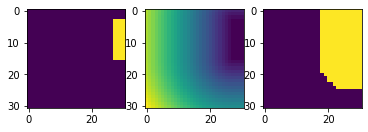

In [248]:
dt = distance_transform_edt(np.logical_not(bmap2[342]))
_, (ax1, ax2, ax3) = plt.subplots(ncols=3)
ax1.imshow(bmap2[342])
ax2.imshow(dt)
ax3.imshow(dt < 10)

In [237]:
emc.run_frame_sparse(iterations=10, frame_drifts_in_use=frame_drifts_in_use, lpfs=1.5)

100%|██████████| 10/10 [00:03<00:00,  3.14it/s]                                                                        


(961, 500)

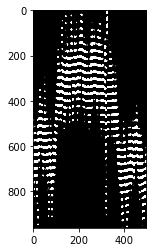

In [238]:
plt.imshow(emc.membership_probability, vmin=0, vmax=0.0001, cmap='gray')
emc.membership_probability.shape

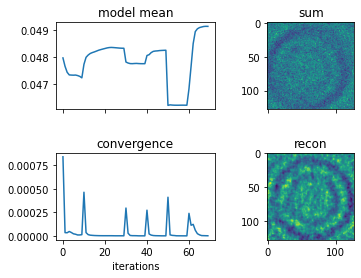

In [239]:
fig = emc2d.viz.show_emc_state(emc)

mse = 37.346


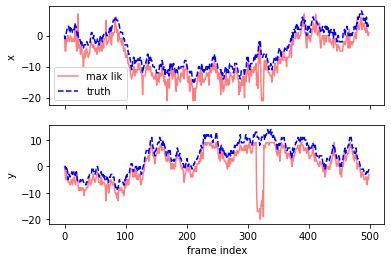

In [240]:
recon_drifts, recon_model = emc.centre_by_first_frame()
mse = emc2d.sim.mse_error(recon_drifts, true_traj=traj)
fig2 = emc2d.viz.show_maximum_likelihood_drifts(emc, true_traj=traj)

print(f"mse = {mse}")

In [157]:
pmat2 = emc.folded_membership_probability

Text(0.5, 1.0, 'refined')

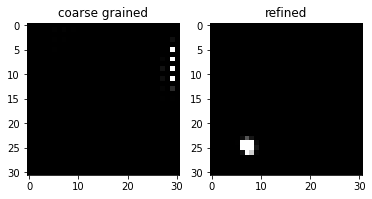

In [158]:
k = 342
_, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(pmat0[k], cmap='gray', vmin=0, vmax=0.01)
ax2.imshow(pmat2[k], cmap='gray', vmin=0, vmax=0.01)
ax1.set_title("coarse grained")
ax2.set_title("refined")

In [49]:
bmap2 = emc.binary_location_map(threshold=1e-3)

In [50]:
bmap2_c = add_continuity(bmap2)
bmap2_b = broaden_searching_regions(bmap2_c, r=3)
bmap2_l = impose_locality(bmap2_b)

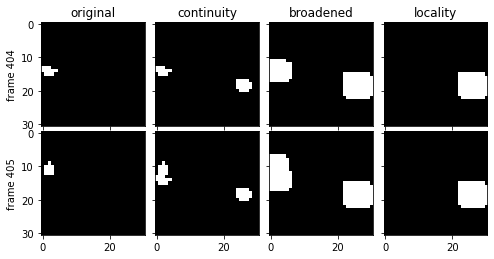

In [56]:
k0 = 404
k1 = k0 + 1
_, ((ax1, ax3, ax5, ax7), (ax2, ax4, ax6, ax8)) = plt.subplots(nrows=2, ncols=4, sharex='all', sharey='all', figsize=(8, 4))
ax1.imshow(  bmap2[k0], cmap="gray")
ax2.imshow(  bmap2[k1], cmap="gray")
ax3.imshow(bmap2_c[k0], cmap="gray")
ax4.imshow(bmap2_c[k1], cmap="gray")
ax5.imshow(bmap2_b[k0], cmap="gray")
ax6.imshow(bmap2_b[k1], cmap="gray")
ax7.imshow(bmap2_l[k0], cmap="gray")
ax8.imshow(bmap2_l[k1], cmap="gray")

ax1.set_ylabel(f"frame {k0}")
ax2.set_ylabel(f"frame {k1}")
ax1.set_title("original")
ax3.set_title("continuity")
ax5.set_title("broadened")
ax7.set_title("locality");
plt.subplots_adjust(hspace=0, wspace=0.1)